# RMSD of the protein


We are going to use a basic root mean-squared deviation here to demonstrate how static the protein is within the system. In the selection below, fill in the SELECT = 'YOUR SELECTION' to select the backbone beads of the protein.  

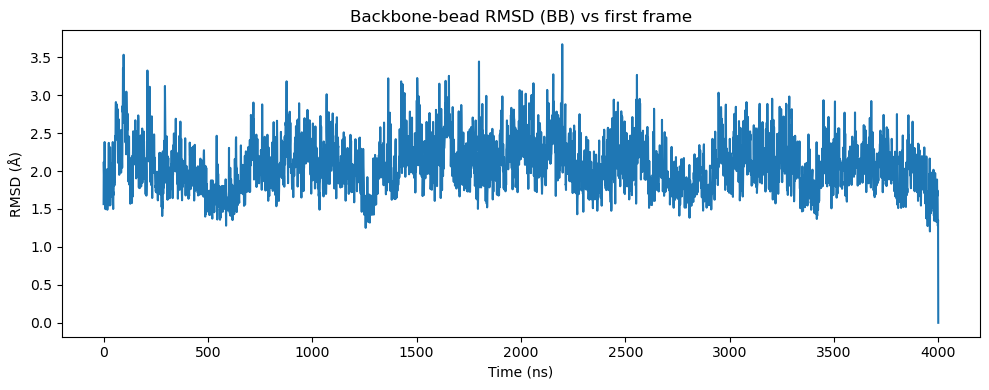

In [3]:
# === Version 1.2 ===
# RMSD of backbone beads (name BB) vs FIRST FRAME.

import MDAnalysis as mda
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt
import numpy as np

TOPOLOGY = "traj.pdb"
TRAJECTORY = "traj_1ns.xtc"
SELECT = "name BB"  # backbone beads

u = mda.Universe(TOPOLOGY, TRAJECTORY)

# Reference = the same system; use frame 0 as the reference
ref = mda.Universe(TOPOLOGY, TRAJECTORY)
ref_frame = -1  # change to -1 for last-frame reference

R = rms.RMSD(u, reference=ref, select=SELECT, ref_frame=ref_frame).run()

frames = R.rmsd[:, 0]
time_ns = frames

rmsd_A = R.rmsd[:, 2]

plt.figure(figsize=(10, 4))
plt.plot(time_ns, rmsd_A, linewidth=1.5)
plt.xlabel('Time (ns)')
plt.ylabel("RMSD (Å)")
plt.title("Backbone-bead RMSD (BB) vs first frame")
plt.tight_layout()
plt.show()


As you can see, the elastic network keeps the rmsd small, with little movement acorss the length of the simulation. This is fine for this system but something to keep in mind if your system undergoes conformational changes. A better approach then might be a Go-Martini approach, or staying within all-atom and using some form of enhanced sampling. 

# The membrane

Load the trajectory in vmd. Visualise the backbone and phosphate head groups and watch the simulation. Do you notice something odd about the headgroup beads at any point during the simulation. Is there the same deformation happening at both leaflets? Make a note of which phosphate beads are involved and try visualising that one. Use resid XXX within VMD to select that residue and then visualise all the atoms with VDW.  

# Membrane deformation

We want to investigate this lipid binding site in more detail. There are a number of ways to do that and we go through a basic one here. 



The first step is for us to declare the upper and lower leaflet. 
As we do not have a lipid scrambling event, this is quite easy and we can use MDAnalysis leaflet finder straight out of the box. The code below selects and plots the two membranes. This gives us which residues are present in each leaflet. 

Note: The trajectory has been processed to correct for pbc conditions and fit on the protein in x and y. Re-imaging (using trjconv etc) for membranes can be a challenge but the gromacs forum usually has something relevant eg https://gromacs.org-gmx-users.maillist.sys.kth.narkive.com/H3x4pfDk/gmx-users-usage-trjconv-in-membrane-simulation

leaflet in MDA: 

https://docs.mdanalysis.org/1.1.1/documentation_pages/analysis/leaflet.html

### leaflet plot
The results are plotted as scatter plots in the XY and XZ planes to show leaflet organization and separation across the bilayer.

✅ Found 2 leaflets
Leaflet 1: 224 PO4 beads, mean z = 114.18 Å
Leaflet 2: 214 PO4 beads, mean z = 74.02 Å


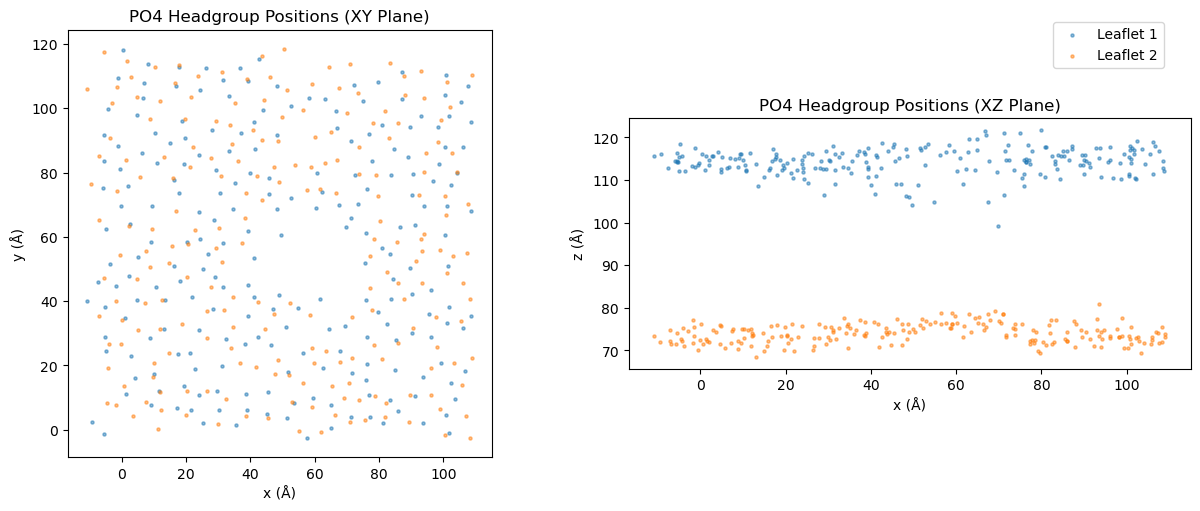

In [ ]:

import MDAnalysis as mda
from MDAnalysis.analysis import leaflet
import matplotlib.pyplot as plt
import numpy as np

# --- Load system ---
u = mda.Universe("traj.pdb", "traj_1ns.xtc")

# --- Select phosphate beads (PO4) ---
lipid_heads = u.select_atoms("resname POPE POPG and name PO4")

# --- Detect leaflets ---
lf = leaflet.LeafletFinder(u, lipid_heads, cutoff=15.0)
leaflets = list(lf.groups())
print(f"✅ Found {len(leaflets)} leaflets")

# --- Report stats ---
for i, group in enumerate(leaflets):
    print(f"Leaflet {i+1}: {len(group)} PO4 beads, mean z = {group.positions[:,2].mean():.2f} Å")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
colors = plt.cm.tab10.colors

for i, group in enumerate(leaflets):
    axes[0].scatter(group.positions[:,0], group.positions[:,1], s=5, alpha=0.5, label=f"Leaflet {i+1}", color=colors[i])
    axes[1].scatter(group.positions[:,0], group.positions[:,2], s=5, alpha=0.5, label=f"Leaflet {i+1}", color=colors[i])

for ax, (xlabel, ylabel, title) in zip(
    axes,
    [("x (Å)", "y (Å)", "PO4 Headgroup Positions (XY Plane)"),
     ("x (Å)", "z (Å)", "PO4 Headgroup Positions (XZ Plane)")]
):
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title, aspect="equal")

# --- Deduplicate legend entries ---
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.98, 0.98), frameon=True)

plt.show()


As we can see, even at the first frame there is already some lipid phosphate bead is clearly quite below the plane of the membrane in the upper leaflet. Lets quantify this some more by looking at the deformation over the final 500 ns. 

## Membrane deformation using lipid height

We use height of the phosphate bead as an easy proxy for lipid bidning to the binding site and deforming the membrane. There are other approaches such as using membrane curvature. 

### First we load everything

We only look at the final 1000 ns within this analyses to make the plots clearer and so we know we are looking at equilibrium behaviour where the lipid has entered the binding site.

In [12]:


import MDAnalysis as mda
from MDAnalysis.analysis import leaflet
import matplotlib.pyplot as plt
import numpy as np

# --- Settings ---
TOPOLOGY = "traj.pdb"
TRAJECTORY = "traj_1ns.xtc"
SELECTION = "resname POPE POPG and name PO4"
LEAFLET_CUTOFF_A = 20.0    # input for leaflet finder 
BIN_A = 1
BOX_MIN, BOX_MAX = 0.0, 100.0      # we focus in to make the plotting neater
SHIFT = 0.5 * (BOX_MAX - BOX_MIN)  # +50 Å shift maps [-50,+50] around protein to [0,100] # these are both for making the plot look nice
SYMMETRIC_SCALE = True

# --- Load traj and frame range ---
u = mda.Universe(TOPOLOGY, TRAJECTORY)
n_frames = len(u.trajectory)
start = max(0, n_frames - 1000)
print(f"Analyzing frames {start} .. {n_frames-1} (total {n_frames-start})")

# --- Leaflets from first analyzed frame ---
u.trajectory[start]
lipid_heads = u.select_atoms(SELECTION)
lf = leaflet.LeafletFinder(u, lipid_heads, cutoff=LEAFLET_CUTOFF_A)
leaflets = list(lf.groups())
print(f"✅ Found {len(leaflets)} leaflets")
for i, g in enumerate(leaflets, 1):
    print(f"Leaflet {i}: {len(g)} PO4 beads (at frame {start})")


Analyzing frames 3001 .. 4000 (total 1000)
✅ Found 2 leaflets
Leaflet 1: 224 PO4 beads (at frame 3001)
Leaflet 2: 214 PO4 beads (at frame 3001)


/khalid/k016/magd5822/miniforge3/envs/ccpbiosim/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


### We iterate through each frame of the trajectory

This part sets up a fixed 0–100 Å XY grid and initializes arrays to record how many lipid headgroups fall into each bin and their average height. For every frame, the system is centered on the protein, and only lipids within the 0–100 Å region are considered. Their x–y positions are binned, and their z-values are added to build up an average leaflet height map around the protein.

In [13]:

# --- Fixed XY bin grid in the shifted local frame (0–100 Å) ---
x_edges = np.arange(BOX_MIN, BOX_MAX + BIN_A, BIN_A)
y_edges = np.arange(BOX_MIN, BOX_MAX + BIN_A, BIN_A)
nx = len(x_edges) - 1
ny = len(y_edges) - 1
print(f"XY box used: x:{BOX_MIN:.1f}–{BOX_MAX:.1f} Å, y:{BOX_MIN:.1f}–{BOX_MAX:.1f} Å; bins: {nx}×{ny} of {BIN_A:.1f} Å.")

# --- Prepare per-leaflet accumulators (region-only) ---
leaflet_info = []
for g in leaflets:
    leaflet_info.append({
        "idx": g.indices,                          # atom indices for this leaflet
        "counts": np.zeros((nx, ny), float),       # per (x,y) bin
        "zsum":   np.zeros((nx, ny), float),       # per (x,y) bin
        "z_total_region": 0.0,                     # leaflet mean (region only)
        "n_total_region": 0
    })

protein = u.select_atoms("protein")
if protein.n_atoms == 0:
    raise ValueError("No 'protein' atoms found; cannot center. Adjust selection if needed.")

# --- Accumulate over frames (protein-centred, shifted, region-only) ---
for ts in u.trajectory[start:]:
    # center on protein (center of geometry)
    center = protein.positions.mean(axis=0)

    for info in leaflet_info:
        pos = u.atoms[info["idx"]].positions - center  # center on protein
        # shift by +50 Å so symmetric window [-50, +50] maps to [0, 100]
        x_local = pos[:, 0] + SHIFT
        y_local = pos[:, 1] + SHIFT
        z = pos[:, 2]

        # region-only mask in the shifted frame
        m = (x_local >= BOX_MIN) & (x_local < BOX_MAX) & (y_local >= BOX_MIN) & (y_local < BOX_MAX)
        if not np.any(m):
            continue

        # histogram within fixed region (points outside are ignored)
        c,  _, _ = np.histogram2d(x_local[m], y_local[m], bins=[x_edges, y_edges])
        zs, _, _ = np.histogram2d(x_local[m], y_local[m], bins=[x_edges, y_edges], weights=z[m])

        info["counts"] += c
        info["zsum"]   += zs
        info["z_total_region"] += float(np.sum(z[m]))
        info["n_total_region"] += int(np.count_nonzero(m))


XY box used: x:0.0–100.0 Å, y:0.0–100.0 Å; bins: 100×100 of 1.0 Å.


### Now let's plot

lets also  make a colour bar that is universal (ie relative to the mean of each leaflet)

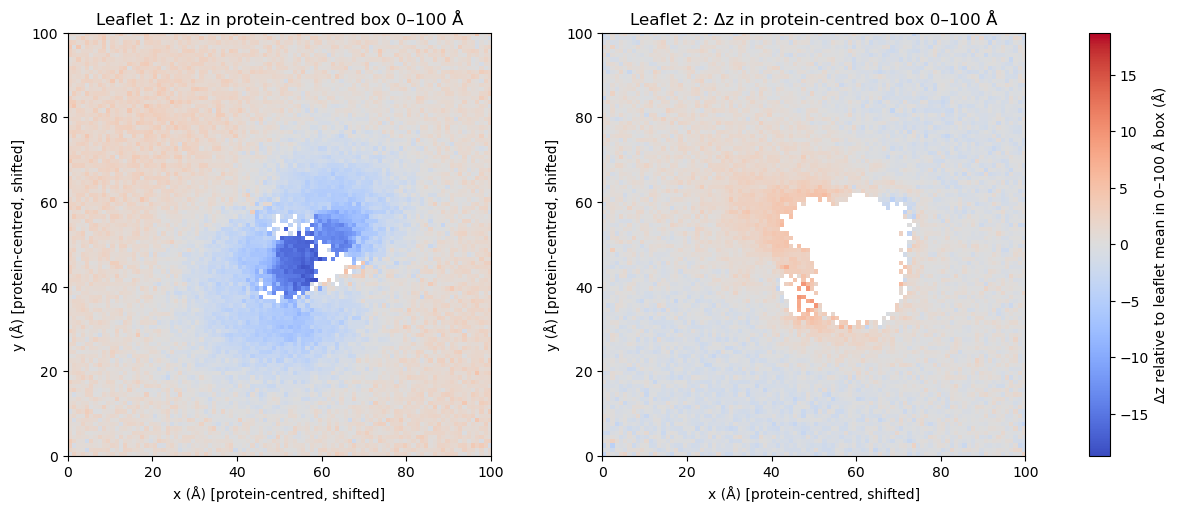

In [14]:

# --- Build Δz grids and compute a universal color scale from all Δz values ---
dz_grids = []
dz_mins = []
dz_maxs = []

for info in leaflet_info:
    # leaflet mean z in the region (over analyzed frames)
    if info["n_total_region"] > 0:
        leaf_mean = info["z_total_region"] / info["n_total_region"]
    else:
        leaf_mean = np.nan

    with np.errstate(invalid="ignore", divide="ignore"):
        zmean = info["zsum"] / info["counts"]  # (nx, ny)

    dz = (zmean - leaf_mean).T  # (ny, nx) for imshow
    empty = info["counts"].T == 0
    dz[empty] = np.nan

    dz_grids.append(dz)
    finite_vals = dz[np.isfinite(dz)]
    if finite_vals.size > 0:
        dz_mins.append(float(np.min(finite_vals)))
        dz_maxs.append(float(np.max(finite_vals)))

# universal symmetric color scale
if dz_mins and dz_maxs:
    vmin_raw = float(np.min(dz_mins))
    vmax_raw = float(np.max(dz_maxs))
    if SYMMETRIC_SCALE:
        vmax = max(abs(vmin_raw), abs(vmax_raw))
        vmin = -vmax
    else:
        vmin, vmax = vmin_raw, vmax_raw
else:
    vmin = vmax = None

# --- Plot: one panel per leaflet, shared colorbar/scale, 'coolwarm' ---
n = len(dz_grids)
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), constrained_layout=True)
if n == 1:
    axs = [axs]

last_im = None
for ax, (i, dz) in zip(axs, enumerate(dz_grids, 1)):
    im = ax.imshow(
        dz,
        origin="lower",
        extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]),
        aspect="equal",
        interpolation="nearest",
        cmap="coolwarm",
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f"Leaflet {i}: Δz in protein-centred box 0–100 Å")
    ax.set_xlabel("x (Å) [protein-centred, shifted]")
    ax.set_ylabel("y (Å) [protein-centred, shifted]")
    last_im = im

cbar = fig.colorbar(last_im, ax=axs)
cbar.set_label("Δz relative to leaflet mean in 0–100 Å box (Å)")
plt.show()


We plot both the upper and lower leaflet and see quite a difference. The upper leaflet has much more deformation and much more entry within the core of the protein (as we expected). There seem to be two sites of deformation. The lower leaflet has some light deformation but nothing extreme.The deformation radiates out from the protein. 

# lets look at a residue in more detail and look at the protein interactions

Pick out the lipid that binds into the pocket of the protein using VMD. Have a look at the pocket in more detail and note what resiudes are interacting. 
what frame does it start interacting? 
When does it leave? 
There are multiple to choose from.

In [21]:
# lets now look at what resiudes are in contact with resid 703 during that period

start_frame = 2100
end_frame = 3950


### Basic lipid contact analysis

Lets choose some parameters. We can enter the start and end frame, what resid we are targetting, and what we define as a contact. there are more robust ways that this (see mdanalysis for more details) but we are using a 7 Angstrom cutoff and a minumum contact time of 2 ns.

In [24]:


import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from MDAnalysis.lib.distances import distance_array

# --- Settings ---
TOPOLOGY = "traj.pdb"
TRAJECTORY = "traj_1ns.xtc"
TARGET_RESID = 703
START_FRAME = start_frame
END_FRAME   = end_frame
CONTACT_CUTOFF_A = 7.0
MIN_CONTACT_FRAMES = 2 # we define a contact here as longer than 10 ns

# --- Load + selections 
u = mda.Universe(TOPOLOGY, TRAJECTORY)
target = u.select_atoms(f"resid {TARGET_RESID} and name PO4 GL0")
protein = u.select_atoms("same resname as name BB")
residues = list(protein.residues)


/khalid/k016/magd5822/miniforge3/envs/ccpbiosim/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


We first define the frame range and create a contact matrix that records whether each protein residue is within a given distance of the target lipid in every frame. We then filter out short, transient contacts so that only stable interactions remain. For each residue, we record the time intervals where contact occurs and note the first frame in which it appears. We sort the residues by their first contact time, classify them by chemical type (such as polar, hydrophobic, or charged), and plot the results as horizontal bars over time. This allows us to see when and for how long each residue interacts with the lipid, with colors indicating residue class.

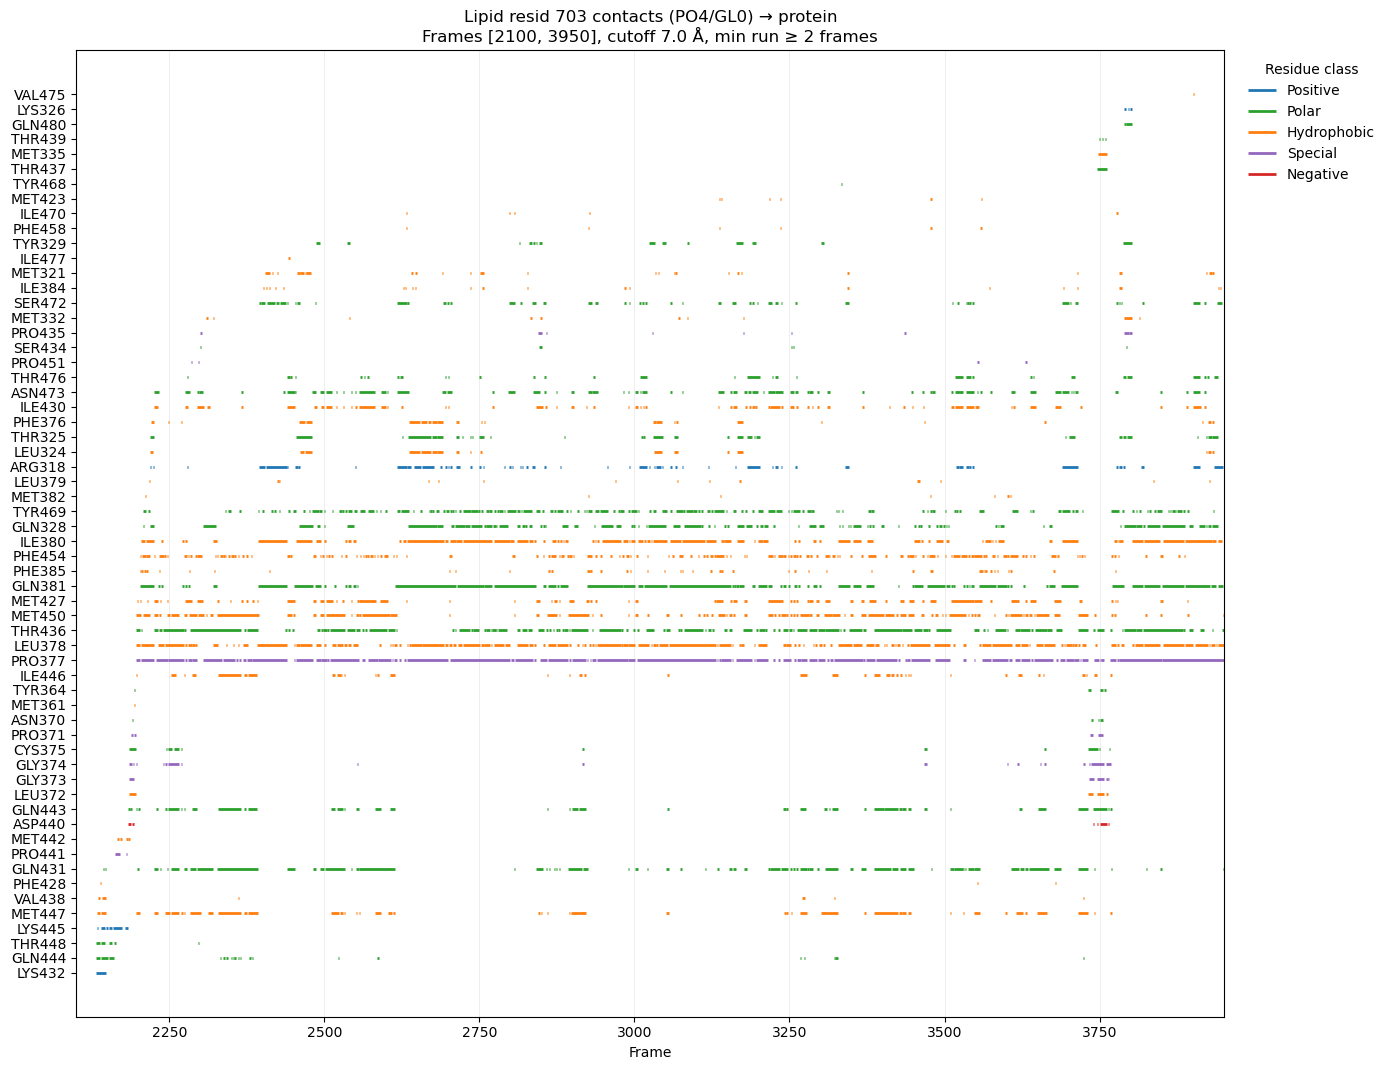

In [25]:

# --- Frame window & storage ---
start, end = START_FRAME, END_FRAME
frame_idx = np.arange(start, end + 1, dtype=int)
n_frames = len(frame_idx)
contact_mat = np.zeros((len(residues), n_frames), dtype=bool)

# --- Raw contact timeline ---
for j, _ in enumerate(u.trajectory[start:end+1]):
    tgt_pos = target.positions
    for i, res in enumerate(residues):
        if np.min(distance_array(tgt_pos, res.atoms.positions)) <= CONTACT_CUTOFF_A:
            contact_mat[i, j] = True

# --- Suppress short runs ---
filtered = contact_mat.copy()
if MIN_CONTACT_FRAMES > 1:
    for i in range(filtered.shape[0]):
        tl = filtered[i]
        k = 0
        while k < n_frames:
            if tl[k]:
                s = k
                while k + 1 < n_frames and tl[k + 1]:
                    k += 1
                e = k
                if (e - s + 1) < MIN_CONTACT_FRAMES:
                    tl[s:e+1] = False
            k += 1

# --- Collect survivors with intervals + first ABSOLUTE contact frame ---
results = []
for i, res in enumerate(residues):
    tl = filtered[i]
    if not tl.any():
        continue
    intervals = []
    first_abs = None
    k = 0
    while k < n_frames:
        if tl[k]:
            s = k
            if first_abs is None:
                first_abs = start + s
            while k + 1 < n_frames and tl[k + 1]:
                k += 1
            e = k
            intervals.append((start + s, start + e))
        k += 1
    results.append({
        "resname": res.resname,
        "resid": int(res.resid),
        "intervals": intervals,
        "first_abs": first_abs
    })

# --- Order by first absolute contact frame (earliest first) ---
results.sort(key=lambda r: (r["first_abs"] if r["first_abs"] is not None else 10**12))

# --- Simple residue class colors ---
pos = {"ARG","LYS","HIS"}
neg = {"ASP","GLU"}
pol = {"SER","THR","ASN","GLN","TYR","CYS"}
hyd = {"ALA","VAL","LEU","ILE","MET","PHE","TRP"}
spec= {"PRO","GLY"}
def class_and_color(resn):
    r = resn.upper()
    if r in pos:  return "Positive",    "tab:blue"
    if r in neg:  return "Negative",    "tab:red"
    if r in pol:  return "Polar",       "tab:green"
    if r in hyd:  return "Hydrophobic", "tab:orange"
    if r in spec: return "Special",     "tab:purple"
    return "Other", "tab:gray"

# --- Plot (X = absolute frame numbers) ---
if results:
    fig, ax = plt.subplots(figsize=(14, max(4, 0.18*len(results))))
    added_class = set()
    yticks, ylabels = [], []

    for y, r in enumerate(results):
        cls, col = class_and_color(r["resname"])
        leg = cls if cls not in added_class else None
        for a, b in r["intervals"]:
            ax.hlines(y=y, xmin=a, xmax=b+1, color=col, linewidth=2.0, label=leg)
            leg = None
        added_class.add(cls)
        yticks.append(y)
        ylabels.append(f"{r['resname']}{r['resid']}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Frame")
    ax.set_title(
        f"Lipid resid {TARGET_RESID} contacts (PO4/GL0) → protein\n"
        f"Frames [{start}, {end}], cutoff {CONTACT_CUTOFF_A} Å, min run ≥ {MIN_CONTACT_FRAMES} frames"
    )
    ax.grid(True, axis="x", linewidth=0.5, alpha=0.3)
    ax.set_xlim(start, end + 1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))

    # Legend outside, right
    ax.legend(title="Residue class", frameon=False, loc="upper left", bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.show()
else:
    print("No residues passed the contact-duration filter; nothing to plot.")


One should use bead type to do a proper separation of what is actually a polar interaction eg through the backbone beads or through the side chain beads but for now this is a nice proxy. Now have a look in VMD. 

A nice visualisation to look at this is to use: same resid as ((same resname as name BB) and within 7 of resid 703) 
Use a dynamics bond visulation and a cutoff of 4.5. 

This will select all resiudues of the protein that have a bead within 7 Angstrom of the selected lipid. Visualise the lipid of interest and the PO4 beads as well. Watch the lipid enter. Do you think there is a gate forming that traps the lipid? 

Do you think this pore is empty? Is there something else the headgroup could be interacting with?